In [1]:
import kdsource.histograms as kdh

geometria = [True, 15, 15, 100, 3, 3]
z0 = 30
fuente_original = ["monoenergetica", "colimada"]

N_original = int(1e6)

columns_order = ["ln(E0/E)", "x", "y", "mu", "phi"]
micro_bins = [500] * len(columns_order)
# micro_bins = [50000, 40000, 35000,35000,30000]
macro_bins = [12, 12, 12, 12]
type = "equal_bins"
used_defined_edges = [
    [2.995732273553991 + 1e-9],
    # None,
    [-1.5, 1.5],
    [-1.5, 1.5],
    [1 - 1e-9],
    # None,
    None,
]

surface = kdh.SurfaceTrackProcessor(
    "/home/lucas/Documents/Proyecto_Integrador/PI/segundo_semestre/sources/source1/surface_source.h5",
    int(4.5e8),
)

surface.load_data()





Number of particles in file /home/lucas/Documents/Proyecto_Integrador/PI/segundo_semestre/sources/source1/surface_source.h5: 19180706
100% n, 0% g, 0% e-, 0% e+, 0% p, 


In [ ]:
import numpy as np

surface_df = surface.df

x = surface_df["x"].values
y = surface_df["y"].values
mu = surface_df["mu"].values
phi = surface_df["phi"].values
letargia = surface_df["ln(E0/E)"].values


# np.savetxt('x_values.txt', x)
# np.savetxt('y_values.txt', y)
# np.savetxt('mu_values.txt', mu)
# np.savetxt('phi_values.txt', phi)
# np.savetxt('letargia_values.txt', letargia)

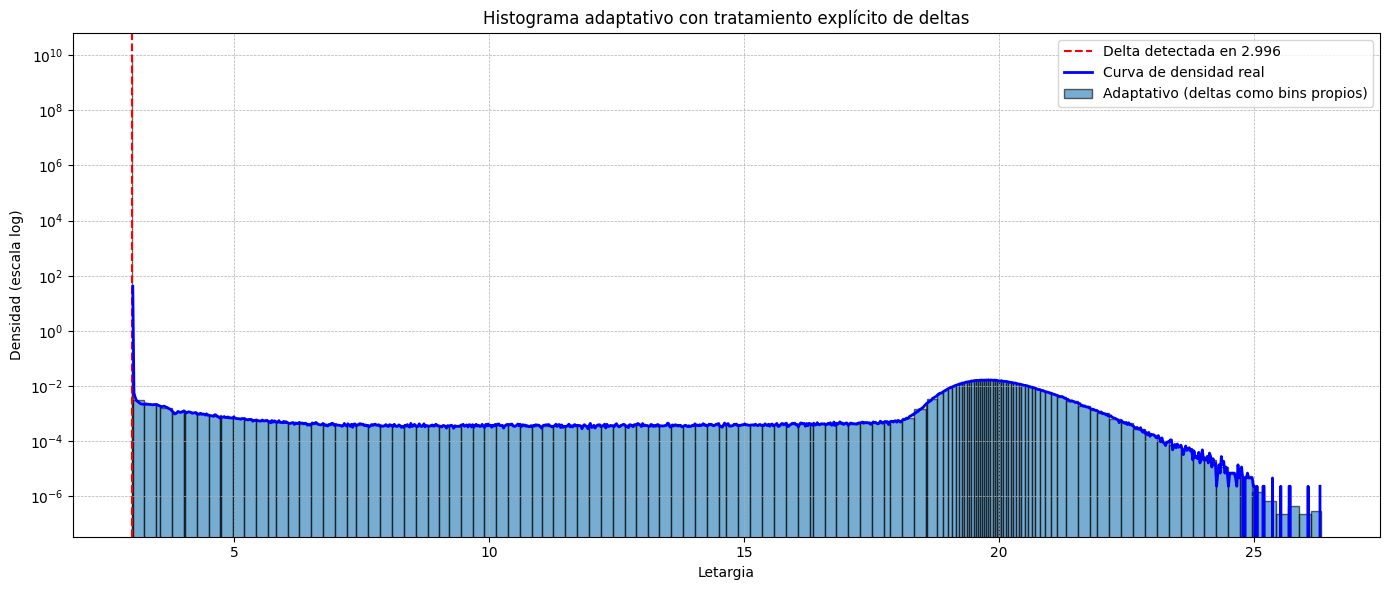

array([ 2.99573227,  2.99573227,  2.99573306,  3.01456043,  3.22712427,
        3.46031061,  3.54321906,  3.77640539,  4.00959173,  4.02804381,
        4.26123014,  4.49441648,  4.72760282,  4.73111189,  4.96429823,
        5.19748457,  5.4306709 ,  5.66385724,  5.81192899,  6.04511533,
        6.27830166,  6.511488  ,  6.74467434,  6.97786067,  7.21104701,
        7.39258237,  7.6257687 ,  7.85895504,  8.09214138,  8.32532771,
        8.55851405,  8.79170038,  9.02488672,  9.20730649,  9.44049282,
        9.67367916,  9.9068655 , 10.14005183, 10.37323817, 10.60642451,
       10.83961084, 11.02944423, 11.26263056, 11.4958169 , 11.72900324,
       11.96218957, 12.19537591, 12.42856225, 12.66174858, 12.87602153,
       13.10920787, 13.3423942 , 13.57558054, 13.80876688, 14.04195321,
       14.27513955, 14.50832589, 14.65537145, 14.88855779, 15.12174413,
       15.35493046, 15.5881168 , 15.82130314, 16.05448947, 16.28767581,
       16.34898447, 16.58217081, 16.81535715, 17.04854348, 17.28

In [13]:
import matplotlib.pyplot as plt

def adaptive_binning_excluding_deltas(data, num_bins=60, delta_threshold=0.01, max_bin_width=None):
    """
    Binning adaptativo excluyendo deltas (valores con alta concentración) 
    y tratándolos como bins individuales.

    Parameters:
    - data: array de datos 1D
    - num_bins: número total de bins (aproximado)
    - delta_threshold: proporción mínima para considerar un valor como delta
    - max_bin_width: ancho máximo permitido para cada bin

    Returns:
    - bin_edges: bordes de bins incluyendo deltas como bordes únicos
    - deltas: lista de valores considerados delta
    """
    data_sorted = np.sort(data)
    total_count = len(data_sorted)

    # Detectar deltas
    unique_vals, counts = np.unique(data_sorted, return_counts=True)
    delta_mask = counts > (delta_threshold * total_count)
    delta_vals = unique_vals[delta_mask]
    delta_counts = counts[delta_mask]

    # Separar datos no delta
    mask_non_delta = ~np.isin(data_sorted, delta_vals)
    data_non_delta = data_sorted[mask_non_delta]

    # Binning adaptativo sobre datos no delta
    quantiles = np.linspace(0, 1, num_bins - len(delta_vals) + 1)
    non_delta_edges = np.quantile(data_non_delta, quantiles)

    # Combinar bordes con deltas como bins degenerados
    bin_edges = list(non_delta_edges)
    for val in delta_vals:
        bin_edges.append(val)
        bin_edges.append(val + 1e-10)  # separamos ligeramente para formar un bin real
    bin_edges = np.unique(np.sort(bin_edges))

    # Limitar el tamaño máximo de bin si se especifica
    if max_bin_width is not None:
        new_edges = [bin_edges[0]]
        for i in range(1, len(bin_edges)):
            prev = new_edges[-1]
            curr = bin_edges[i]
            while (curr - prev) > max_bin_width:
                prev += max_bin_width
                new_edges.append(prev)
            if new_edges[-1] != curr:
                new_edges.append(curr)
        bin_edges = np.array(new_edges)

    return bin_edges, list(delta_vals)

range_letargia = letargia.max() - letargia.min()
max_width_1percent = 0.01 * range_letargia

# Aplicamos el binning adaptativo excluyendo la delta
bin_edges_final, detected_deltas_final = adaptive_binning_excluding_deltas(
    letargia,
    num_bins=60,
    delta_threshold=0.01,
    max_bin_width=max_width_1percent
)

# Histograma final con deltas tratadas aparte
hist_final, _ = np.histogram(letargia, bins=bin_edges_final, density=True)
centers_final = (bin_edges_final[:-1] + bin_edges_final[1:]) / 2
widths_final = np.diff(bin_edges_final)

# Graficamos
plt.figure(figsize=(14, 6))
# plt.plot(fine_centers, fine_hist_density, label='Histograma fino (1000 bins)', alpha=0.5)
plt.bar(centers_final, hist_final, width=widths_final,
    align='center', alpha=0.6, edgecolor='black', label='Adaptativo (deltas como bins propios)')
for val in detected_deltas_final:
    plt.axvline(val, color='red', linestyle='--', label=f'Delta detectada en {val:.3f}')

# Agregar la curva de densidad real
density, bins, _ = plt.hist(letargia, bins=1000, density=True, alpha=0)
bin_centers = 0.5 * (bins[1:] + bins[:-1])
plt.plot(bin_centers, density, label='Curva de densidad real', color='blue', linewidth=2)

plt.yscale('log')
plt.xlabel('Letargia')
plt.ylabel('Densidad (escala log)')
plt.title('Histograma adaptativo con tratamiento explícito de deltas')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

bin_edges_final


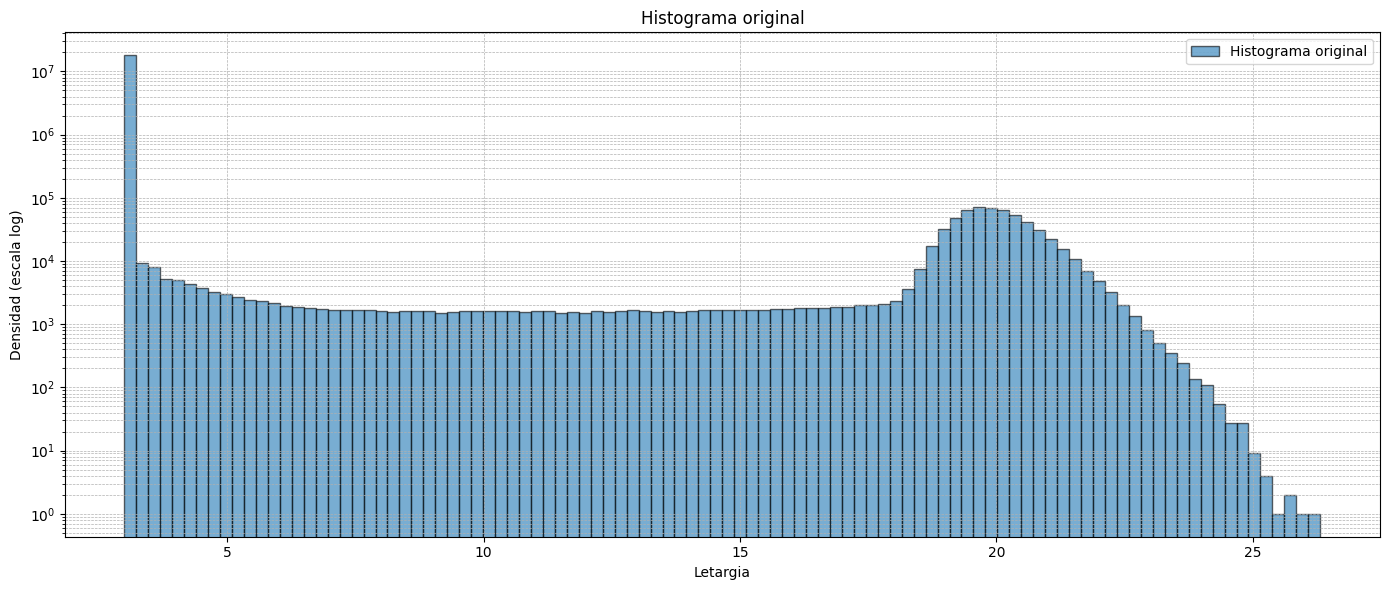

In [15]:
cuentas, edges = np.histogram(
    letargia,
    bins = 100,
    density = False
)
centers = (edges[:-1] + edges[1:]) / 2
widths = np.diff(edges)
plt.figure(figsize=(14, 6))
plt.bar(centers, cuentas, width=widths,
    align='center', alpha=0.6, edgecolor='black', label='Histograma original')
plt.yscale('log')
plt.xlabel('Letargia')
plt.ylabel('Densidad (escala log)')
plt.title('Histograma original')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [18]:
import numpy as np

def bineado_adaptativo_progresivo(data, ancho_minimo=1e-12, bins_iniciales=100, tolerancia_balance=0.05):
    """
    Realiza bineado adaptativo progresivo sobre un array unidimensional.
    
    Parámetros:
    - data: array-like, datos numéricos (letargia de partículas)
    - ancho_minimo: float, ancho mínimo permitido para un bin
    - bins_iniciales: int, número de bins para el histograma inicial
    - tolerancia_balance: float, tolerancia para considerar que dos grupos están "balanceados"
    
    Retorna:
    - bin_edges: np.array, bordes de los bins adaptativos
    """

    bin_edges = np.linspace(data.min(), data.max(), bins_iniciales + 1).tolist()

    # Iterativamente refinar los bines
    terminado = False
    while not terminado:
        terminado = True
        nuevos_edges = []
        for i in range(len(bin_edges) - 1):
            left, right = bin_edges[i], bin_edges[i+1]
            bin_data = data[(data >= left) & (data < right)]

            if len(bin_data) == 0:
                nuevos_edges.append(left)
                continue

            # Almacenar inicio del bin
            nuevos_edges.append(left)

            # Solo refinar si el ancho es mayor que el mínimo
            if (right - left) <= ancho_minimo:
                continue

            log_cuenta = np.log10(len(bin_data))
            
            # Calcular umbral logarítmico en cada iteración base
            if i == 0:
                log_cuentas = []
                for j in range(len(bin_edges) - 1):
                    count = np.sum((data >= bin_edges[j]) & (data < bin_edges[j+1]))
                    if count > 0:
                        log_cuentas.append(np.log10(count))
                log_umbral = np.mean(log_cuentas)

            if log_cuenta > log_umbral:
                terminado = False  # Necesitamos otra pasada
                sorted_bin = np.sort(bin_data)
                total = len(sorted_bin)
                
                # Buscar el punto que divide en dos grupos lo más parejos posible
                mitad = total // 2
                medio_valor = sorted_bin[mitad]

                # Evitar bins nulos (por si todos los valores son iguales)
                if medio_valor == left or medio_valor == right:
                    if (right - left) > ancho_minimo:
                        medio_valor = left + ancho_minimo
                    else:
                        continue  # No se puede dividir más

                nuevos_edges.append(medio_valor)
            else:
                continue  # No refinar este bin

        # Añadir último borde si no estaba incluido
        nuevos_edges.append(bin_edges[-1])

        # Evitar duplicados y ordenar
        bin_edges = sorted(set(nuevos_edges))

    return np.array(bin_edges)

def bineado_adaptativo_rapido(data, ancho_minimo=1e-12, bins_iniciales=100, tolerancia_balance=0.05):
    """
    Bineado adaptativo optimizado para grandes volúmenes de datos.
    """

    # Paso 1: Bins iniciales y umbral log10
    hist_init, edges_init = np.histogram(data, bins=bins_iniciales)
    log_counts = np.log10(hist_init[hist_init > 0])
    log_threshold = np.mean(log_counts)

    # Inicializar lista de bordes
    bin_edges = list(edges_init)

    # Loop hasta que no se puedan refinar más
    terminado = False
    while not terminado:
        terminado = True
        nuevos_edges = []

        # Crear array de bins a procesar
        bin_edges = np.array(bin_edges)
        indices = np.searchsorted(np.sort(data), bin_edges)

        for i in range(len(bin_edges) - 1):
            left = bin_edges[i]
            right = bin_edges[i + 1]
            ancho = right - left

            # Agregar borde izquierdo
            nuevos_edges.append(left)

            if ancho <= ancho_minimo:
                continue

            # Filtrar datos una vez
            mask = (data >= left) & (data < right)
            bin_data = data[mask]
            count = len(bin_data)

            if count == 0:
                continue

            log_count = np.log10(count)

            # Si supera el umbral, dividir el bin
            if log_count > log_threshold:
                terminado = False
                mitad = count // 2

                # Mediana eficiente
                if count > 1:
                    split_point = np.partition(bin_data, mitad)[mitad]
                else:
                    split_point = bin_data[0]

                # Asegurar ancho mínimo
                if (split_point <= left) or (split_point >= right):
                    split_point = left + ancho_minimo
                    if split_point >= right:
                        continue

                nuevos_edges.append(split_point)

        nuevos_edges.append(bin_edges[-1])

        # Eliminar duplicados, mantener orden
        bin_edges = np.unique(nuevos_edges)

    return bin_edges

bin_edges_adaptativo = bineado_adaptativo_rapido(letargia, ancho_minimo=1e-12, bins_iniciales=100, tolerancia_balance=0.05)
cuentas_adaptativo, edges_adaptativo = np.histogram(
    letargia,
    bins=bin_edges_adaptativo,
    density=False
)
centers_adaptativo = (edges_adaptativo[:-1] + edges_adaptativo[1:]) / 2
widths_adaptativo = np.diff(edges_adaptativo)
plt.figure(figsize=(14, 6))
plt.bar(centers_adaptativo, cuentas_adaptativo, width=widths_adaptativo,
    align='center', alpha=0.6, edgecolor='black', label='Histograma adaptativo progresivo')
plt.yscale('log')
plt.xlabel('Letargia')
plt.ylabel('Densidad (escala log)')
plt.title('Histograma adaptativo progresivo')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


KeyboardInterrupt: 

[4.12331408e+01 5.56941296e-03 3.90064927e-03 3.00102770e-03
 2.75609256e-03 2.53175944e-03 2.33718480e-03 2.20899445e-03
 2.18839243e-03 2.16779041e-03 2.13803194e-03 2.25248761e-03
 2.15176662e-03 2.17465775e-03 2.11285169e-03 2.13574282e-03
 2.08309321e-03 2.05791297e-03 2.12658637e-03 2.08538233e-03
 2.14947750e-03 2.03960006e-03 1.93201173e-03 1.85647099e-03
 1.73056975e-03 1.78550847e-03 1.84273630e-03 1.80839960e-03
 1.69623305e-03 1.64587255e-03 1.53141688e-03 1.46961082e-03
 1.39635919e-03 1.22696479e-03 1.13997848e-03 9.63716751e-04
 9.82029658e-04 1.04841395e-03 1.19033898e-03 1.14226760e-03
 1.08732888e-03 1.13997848e-03 1.17202607e-03 1.24985593e-03
 1.16286962e-03 1.04154661e-03 1.11250912e-03 1.14913494e-03
 1.12624380e-03 1.08961799e-03 1.02323370e-03 1.04383572e-03
 1.06214863e-03 1.08046154e-03 9.43114730e-04 9.63716751e-04
 9.36247390e-04 1.02094459e-03 9.33958276e-04 9.61427637e-04
 9.43114730e-04 8.74441327e-04 9.72873204e-04 8.62995760e-04
 8.72152214e-04 8.332372

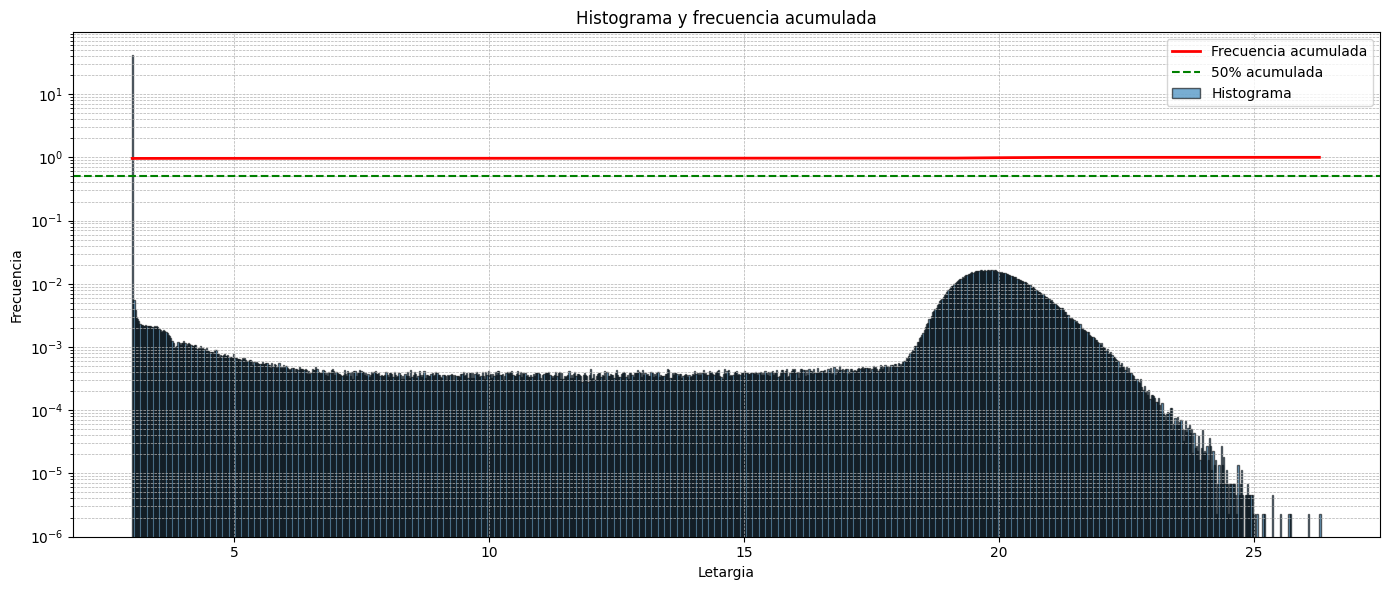

Índice encontrado: 0
Punto que divide la muestra en dos: 3.0074


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def punto_mitad_por_histograma(data, bins=1000):
    """
    Encuentra el punto que divide el conjunto en dos partes con igual cantidad de datos
    usando un histograma y su frecuencia acumulada.

    Retorna:
    - valor estimado del punto que divide la muestra en dos (mediana aproximada)
    """

    # Crear histograma
    counts, edges = np.histogram(data, bins=bins, density=True)

    # Calcular frecuencia acumulada normalizada
    acumulada = np.cumsum(counts) / counts.sum()
    # Graficar histograma y frecuencia acumulada
    plt.figure(figsize=(14, 6))
    plt.bar(edges[:-1], counts, width=np.diff(edges), align='edge', alpha=0.6, edgecolor='black', label='Histograma')
    plt.plot(edges[:-1], acumulada, color='red', label='Frecuencia acumulada', linewidth=2)
    plt.axhline(0.5, color='green', linestyle='--', label='50% acumulada')
    plt.xlabel('Letargia')
    plt.ylabel('Frecuencia')
    plt.title('Histograma y frecuencia acumulada')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.yscale('log')
    plt.tight_layout()
    plt.show()

    # Encontrar el primer índice donde la acumulada supera el 50%
    idx = np.searchsorted(acumulada, 0.5)
    print(f"Índice encontrado: {idx}")

    # Evitar overflow de índice
    if idx >= len(edges) - 1:
        idx = len(edges) - 2

    # Devolver el punto medio del bin correspondiente
    punto_mitad = (edges[idx] + edges[idx + 1]) / 2
    return punto_mitad

# Ejemplo de uso
data = np.loadtxt('letargia_values.txt')
punto_mitad = punto_mitad_por_histograma(data, bins=1000)
print(f"Punto que divide la muestra en dos: {punto_mitad:.4f}")
